In [1]:
import sys
import os
sys.path.append(os.path.abspath(".")) 
import numpy as np

<div style="text-align: center; font-size: 40px;">
    <b>Markov Benchmark</b>
    <br>
    Test on synthetic Data.
    <br>
    
</div>

The purpose of this ntoebook is to evaluate the accuracy of the Markov Based techniques of the DAD library. To assess the accuracy, we run the following experiment. We Generate a random dataset containing : 
- A train set of 1000 sequence of variable length generated by a Markov process whose transition matrix was randomly generated. 
- A test set containing 50% of sequence generated by the above "good" markov process, and 50% of sequence that were generated by 5 different markov process (10% each) whose transition matrix was sufficiently different from the original set and was also randomly generated. 

We then train our classes on the train set and evaluate the accuracy of the performance on the test set. Let's start by importing all the relevant modules from our library.

In [2]:
from MarkovBased import FixedMarkovianBased, VariableMarkovianBased, SparseMarkovTransducer
from BenchMark import MarkovBenchmark

# I) Data Inspection and overview :

Let's start by generating and plotting a random dataset. For plotting we will generate a dataset with seven different symbols. The class also support hidden markov model generation, so we have to set the hidden states matrix to none. 

In [3]:
n_symbols = [2, 3, 5, 7]
n_states = [None for _ in range(len(n_symbols))]

benchmark = MarkovBenchmark(n_symbols_list=n_symbols, n_states_list=n_states,
                               dataset_size=1000, sequence_length=100, proportion_anomalous=0.5
                            )

dataset = benchmark.generate_dataset(7, None) # No hidden states, classical markov model

The `MarkovDataset` object has integrated plot function so we can easily examine it. Let's proceed.

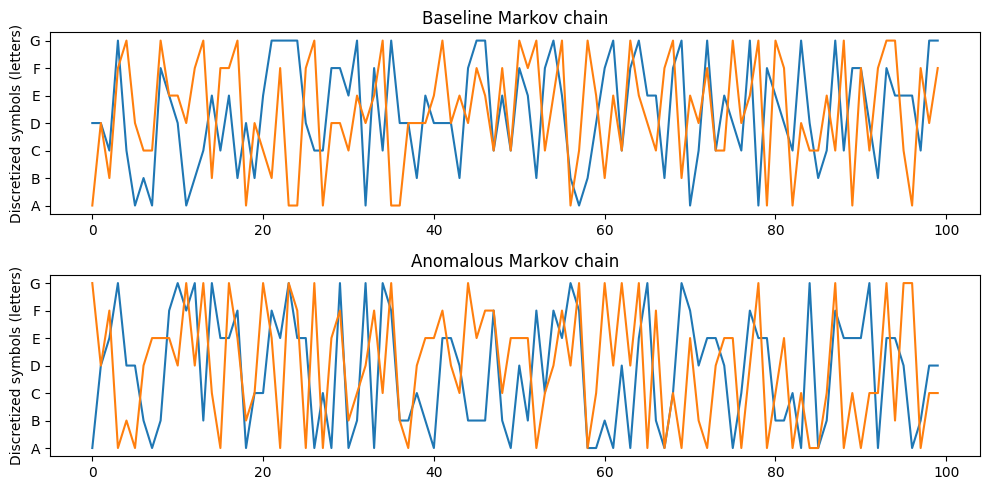

In [4]:
dataset.plot_dataset(n_sequence=2)

They seem  very similar at first sight, and yet, the transition matrices are different. At first glance, let us look at the absolute difference in coefficient between the baseline and anomalous transition matrices using a heatmap on the coefficient of the difference.

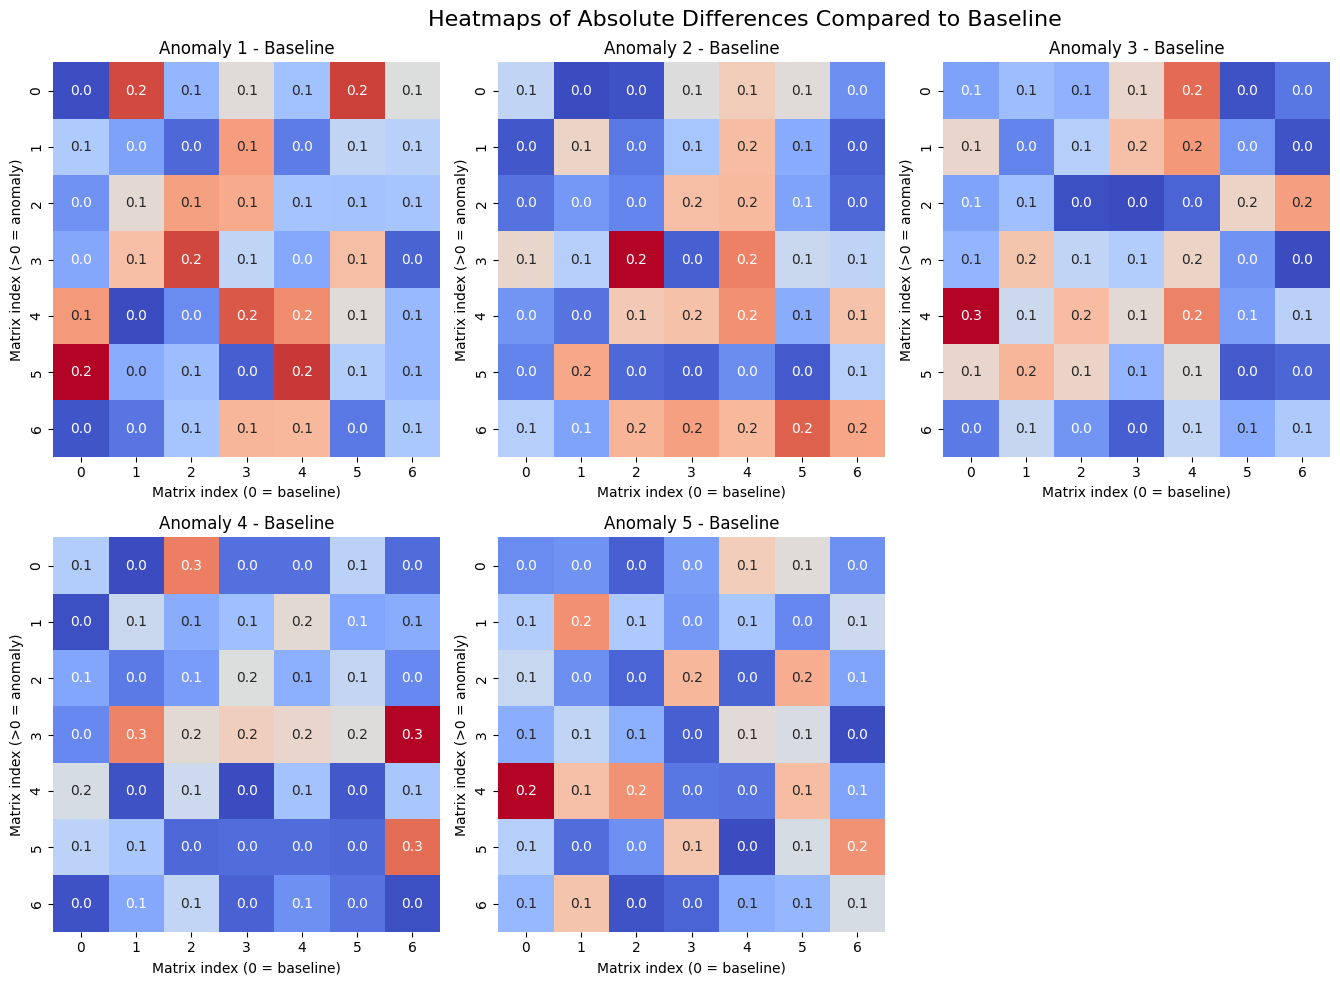

In [5]:
dataset.plot_heatmap()

The heatmap do not provide at first glance a good theoretical grasp on how "different" our models are to each other (ie, if the classification using the Markov model is relevant and appropriate). For that I propose a 2D vizualisation of the differences between the transition matrix used to generate the Markow process. The distance which we deemed more appropriate to compare two transition matrices is the L1-norm. 

In [6]:
def metrics(mat1, mat2): 
    return np.linalg.norm(mat1 - mat2, ord=1)

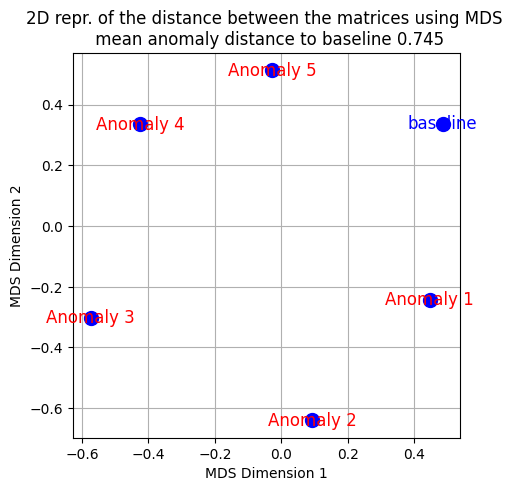

In [7]:
dataset.plot_2D_reduction(metrics, figsize=(5, 5))

We can also look at the L1 distance between the baseline transition matrix and the anomaly, once the distance matrix has been computed and plot it in a 2D graphs using the MDS visualisation techniques. This enables us to see faster how "different" the anomalies are to the baseline. 

In [8]:
dataset.distance_matrix[0]

array([0.        , 0.76617069, 1.02316625, 1.05965445, 0.87431183,
       0.74639949])

# II) Class Benchmark

To benchmark our classes, the metric we will be using is the ROC-AUC score. We thought that the ROC-AUC is a the appropriate metric for evaluating anomaly detection models, particularly because it provides an aggregate measure of model performance across all possible thresholds. It is also robust to **class imbalance** and tells us the ability of the model to **rank the anomaly sequences** well above the normal ones **regardless of the threhold** choosed.Let us generate a global dataset with transition matrices of different size which we will use for each implemented method

In [9]:
n_symbols = [2, 3, 5, 7]
n_states = [None for _ in range(len(n_symbols))]

benchmark = MarkovBenchmark(n_symbols_list=n_symbols, n_states_list=n_states,
                            dataset_size=1000, sequence_length=100, proportion_anomalous=0.5, seed=42) 
dataset_library = benchmark.generate_dataset_library()

## 2.1) Fixed Markovian Based

Now let's see how our classes perform. The `benchmark` method of the `Benchmark` class will output a series of graphs, the rightmost being the distribution of the anomaly score for the anomalous sequence and baseline sequence in the test set, the middle graph being the ROC Curve and the rightmost being a MAD respresentation of the distance between the transition matrices which generated the dataset. 

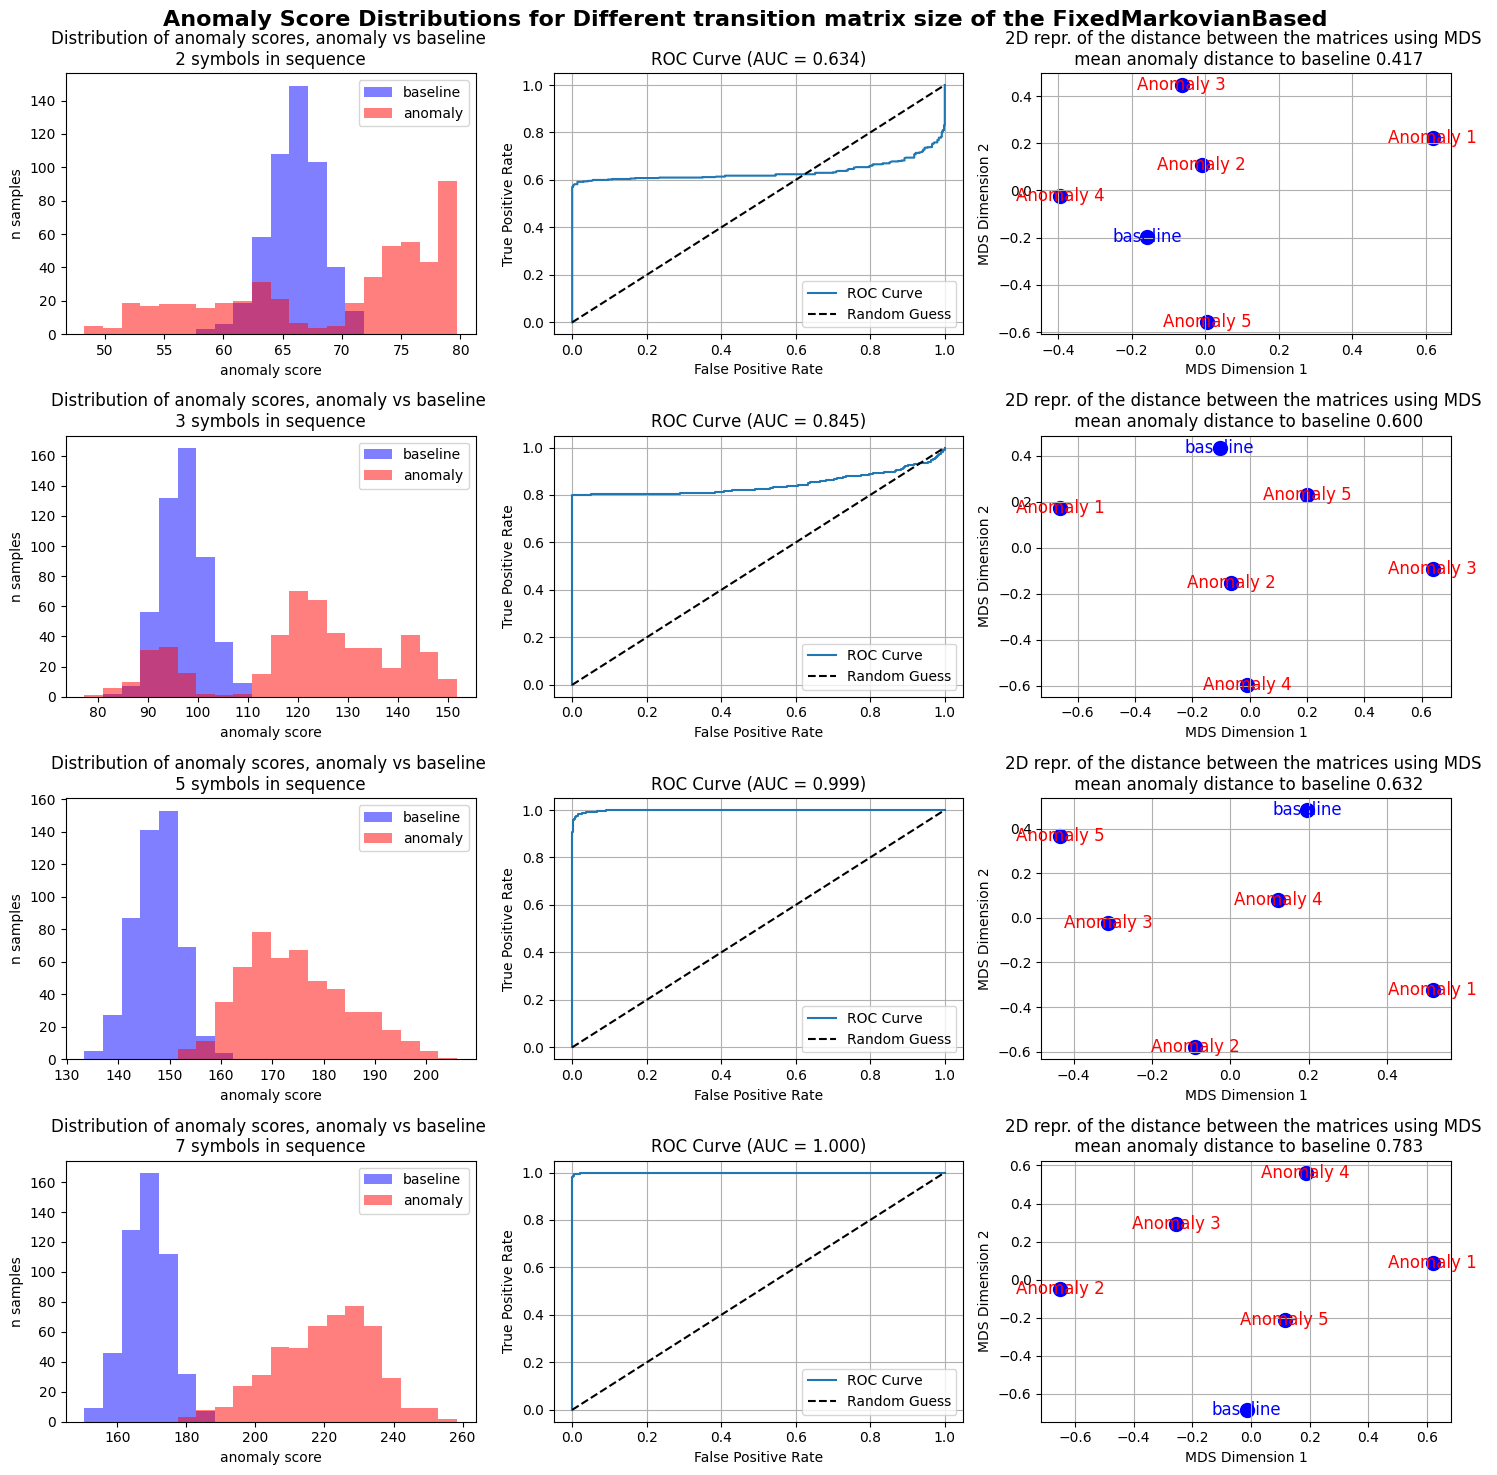

In [10]:
fixed = FixedMarkovianBased(max_depth=2)
benchmark.benchmark(fixed, metrics, dataset_library=dataset_library, figsize=(15, 15))

## 2.2) Variable Markov Based : 

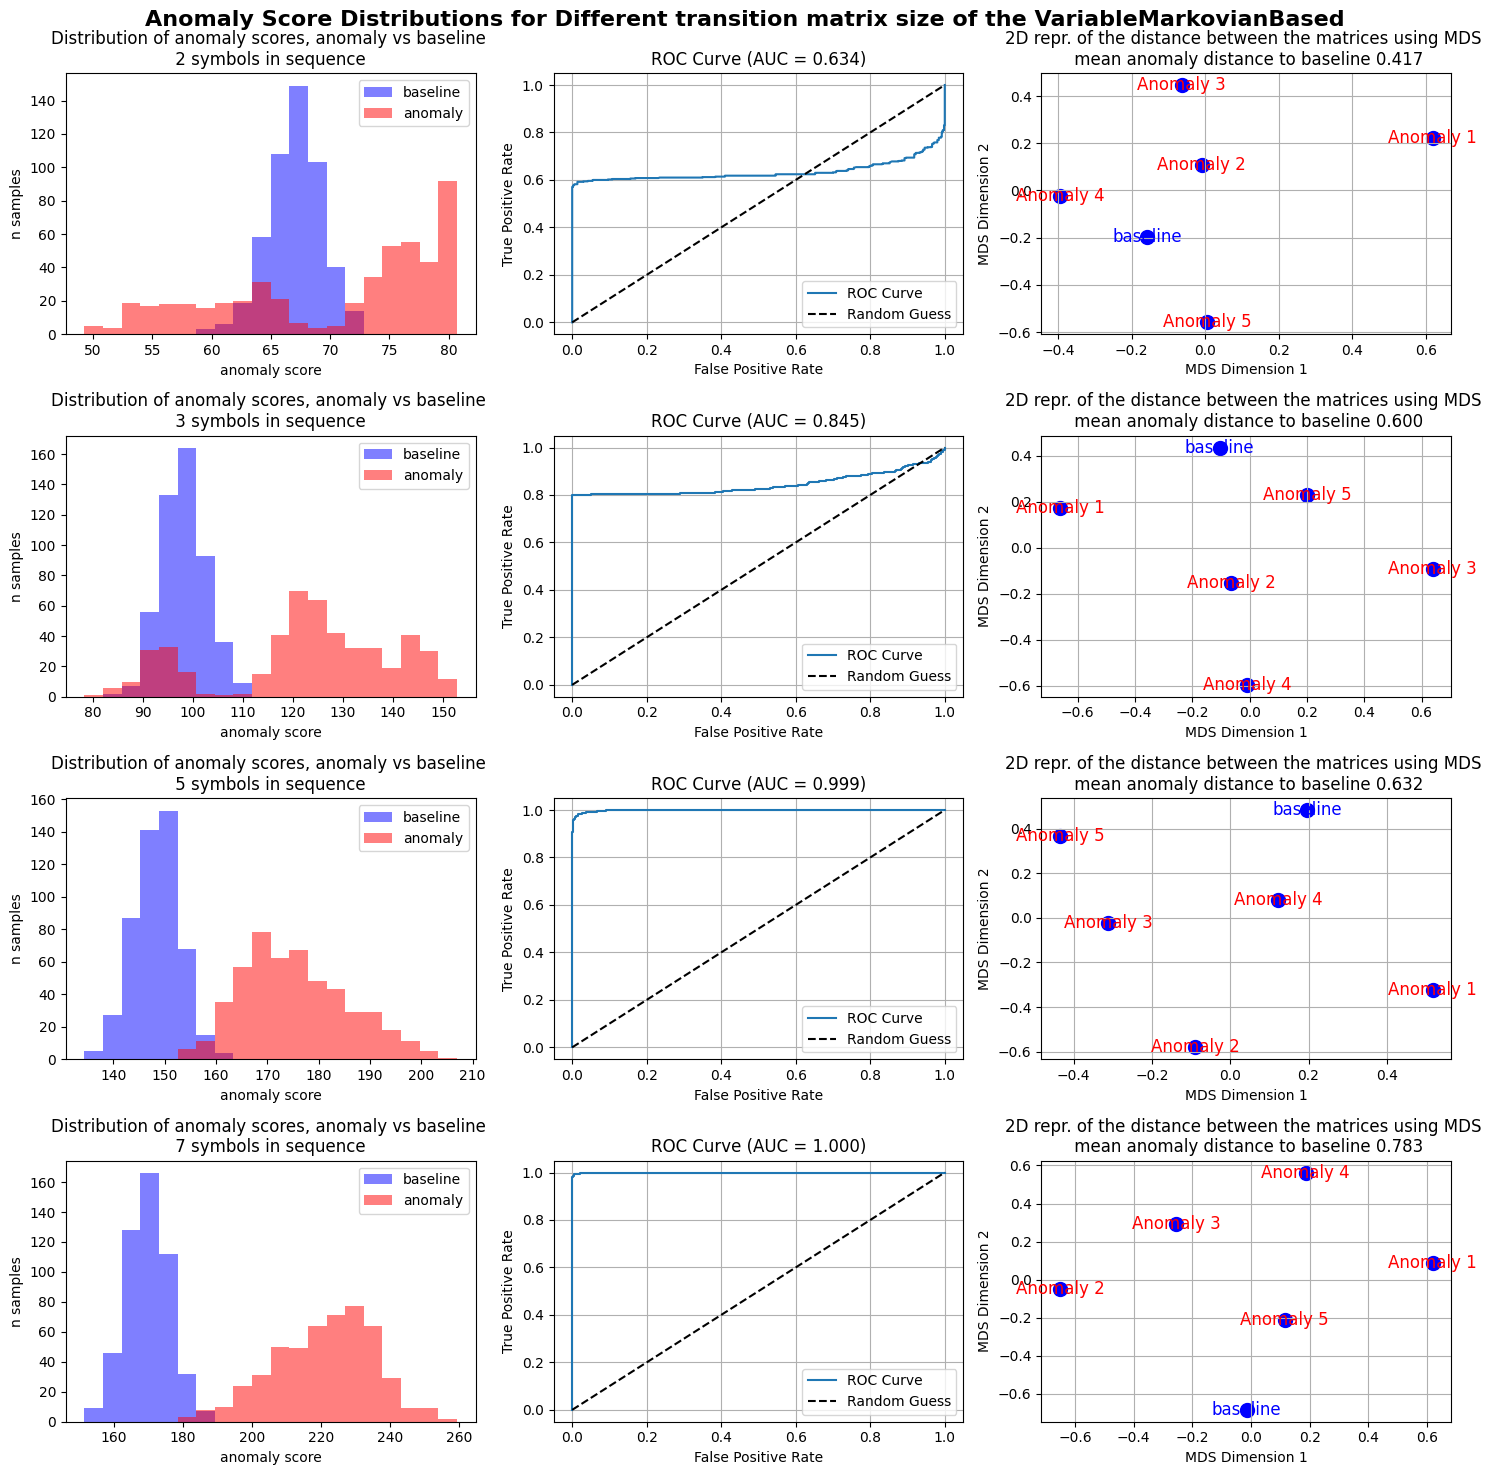

In [11]:
variable = VariableMarkovianBased(max_depth=1)
benchmark.benchmark(variable, metrics, dataset_library=dataset_library, figsize=(15, 15))

# III) Analysis of transition matrices distance on AUC score of the two classes 

Let's regenerate a dataset in low dimension and evaluate how the distance between the transition matrix influence the performance of our predictive algoritm. To generate a new deterministic experiment, let us change the seed in our dataset.

In [12]:
n_symbols = [3, 5]
n_states = [None for _ in range(len(n_symbols))]

benchmark_II = MarkovBenchmark(n_symbols_list=n_symbols, n_states_list=n_states,
                            dataset_size=1000, sequence_length=100, proportion_anomalous=0.5, 
                            seed=10) 
dataset_library_II = benchmark_II.generate_dataset_library()

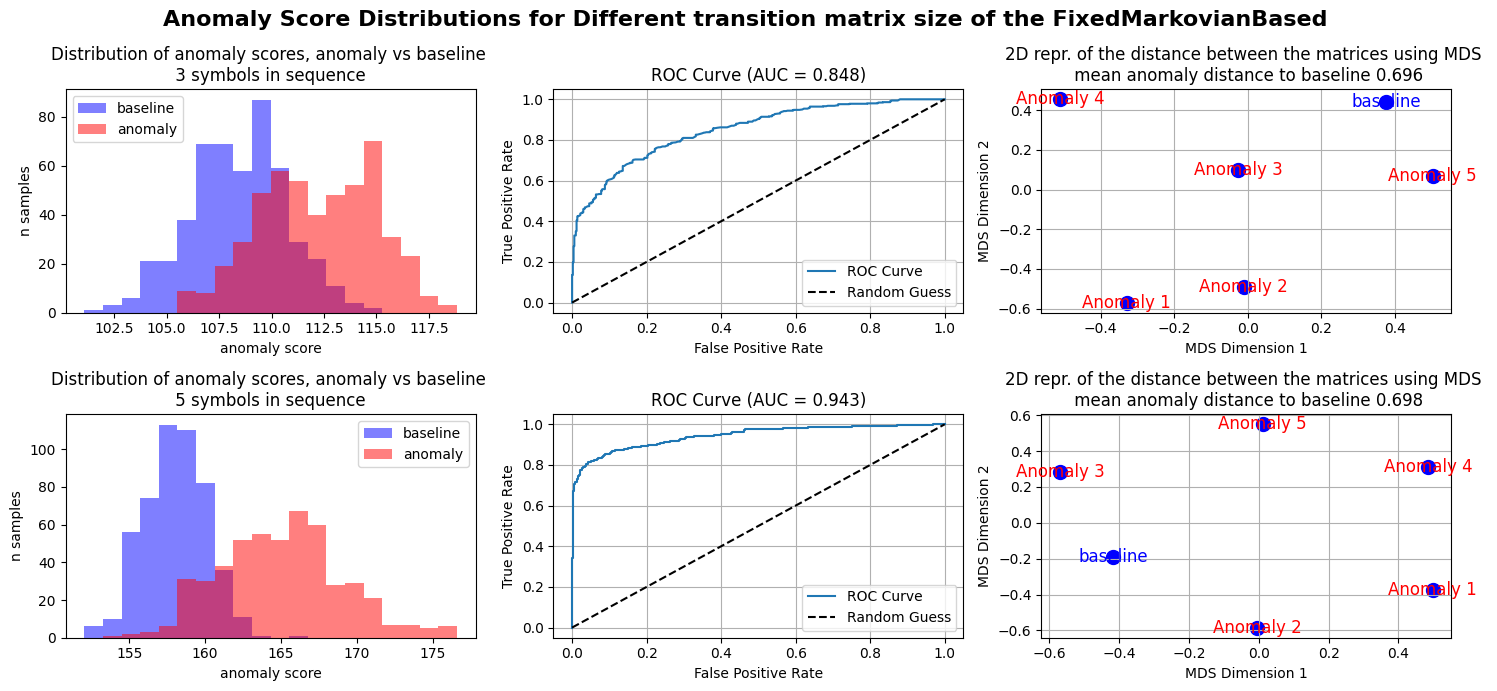

In [13]:
fixed = FixedMarkovianBased(max_depth=1)
benchmark.benchmark(fixed, metrics, dataset_library=dataset_library_II, figsize=(15, 7))

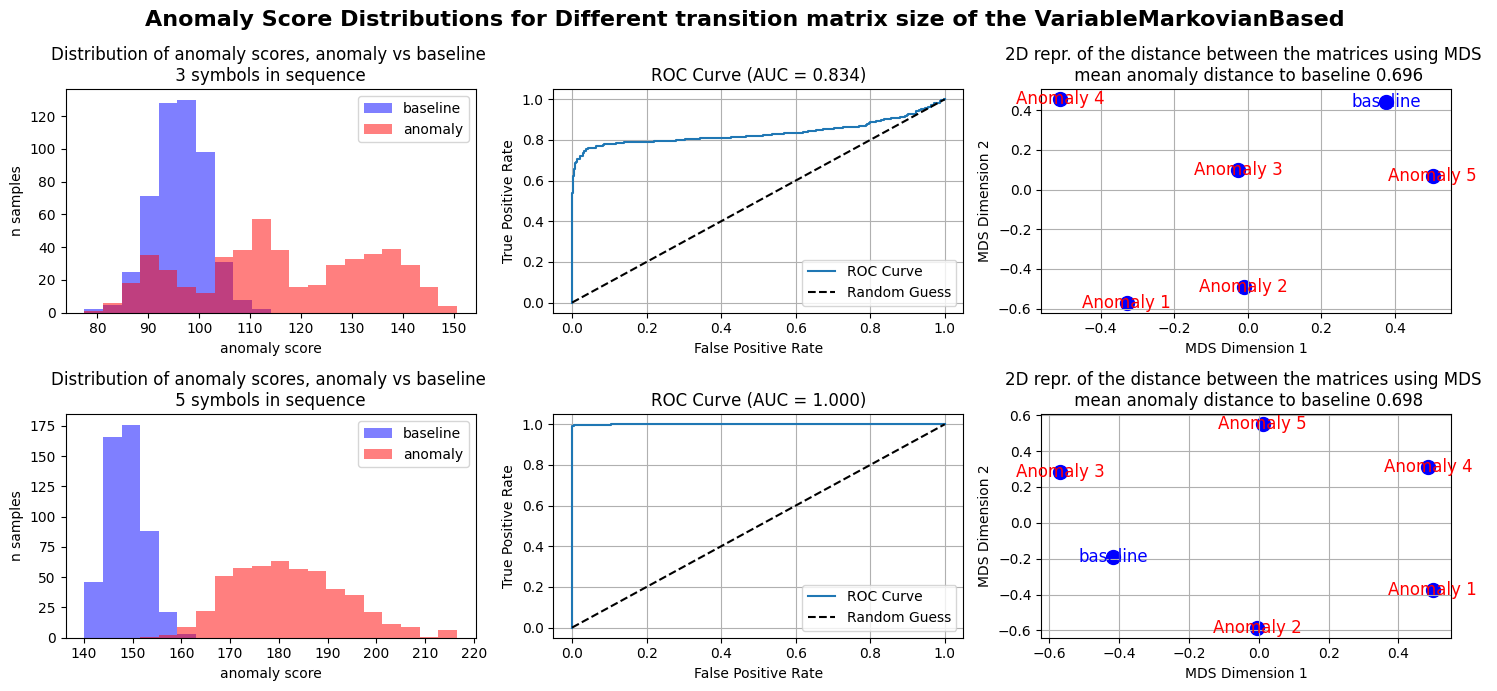

In [14]:
variable = VariableMarkovianBased(max_depth=1)
benchmark.benchmark(variable, metrics, dataset_library=dataset_library_II, figsize=(15, 7))

It seems that higher values of the distance between the baseline and the anomaly in the transition matrix leads to better performance of the model, which is completly coherent since this measures how "different" our markov processes are. We did not have time to run systematic test. 